<a href="https://www.kaggle.com/code/rubanzasilva/s04e05-fastai?scriptVersionId=176190500" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e5/sample_submission.csv
/kaggle/input/playground-series-s4e5/train.csv
/kaggle/input/playground-series-s4e5/test.csv


In [2]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

from fastbook import *
!pip install fastkaggle
!pip install optuna
!pip install optuna_distributed

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.0 MB/s eta 0:00:00


In [3]:
!pip install optuna_distributed

In [4]:
#hide
#! [ -e /content ]

#hide
#This imports and sets up everything you will need for this notebook
#
#!pip install -Uqq fastbook
#import fastbook
#fastbook.setup_book()

#from fastbook import *
#!pip install ucimlrepo
#from ucimlrepo import fetch_ucirepo

from fastai.tabular.all import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import random

from fastai.imports import *
np.set_printoptions(linewidth=130)


from pathlib import Path
import os


from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,r2_score
#from sklearn.metrics import root_mean_squared_error

import xgboost as xgb
from xgboost import plot_importance

import lightgbm as lgb

from catboost import CatBoostClassifier,CatBoostRegressor,Pool, metrics, cv

from ipywidgets import interact


matplotlib.rc('image', cmap='Greys')

from fastkaggle import setup_comp

import optuna

In [5]:
!ls /kaggle/input/playground-series-s4e5

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


sample_submission.csv  test.csv  train.csv


In [6]:
#set_seed(42)

In [7]:
path = Path('/kaggle/input/playground-series-s4e5/')
path

Path('/kaggle/input/playground-series-s4e5')

In [8]:
train_df = pd.read_csv(path/'train.csv',index_col='id')
test_df = pd.read_csv(path/'test.csv',index_col='id')
sub_df = pd.read_csv(path/'sample_submission.csv',index_col='id')

In [9]:
train_df.head()

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
id,,,,,,,,,,,,,,,,,,,,,
0,5,8,5,8,6,4,4,3,3,4,2,5,3,3,5,4,7,5,7,3,0.445
1,6,7,4,4,8,8,3,5,4,6,9,7,2,0,3,5,3,3,4,3,0.450
2,6,5,6,7,3,7,1,5,4,5,6,7,3,7,5,6,8,2,3,3,0.530
3,3,4,6,5,4,8,4,7,6,8,5,2,4,7,4,4,6,5,7,5,0.535
4,5,3,2,6,4,4,3,3,3,3,5,2,2,6,6,4,1,2,3,5,0.415


In [10]:
train_df.shape

(1117957, 21)

In [11]:
cont_names,cat_names = cont_cat_split(train_df, dep_var='FloodProbability')

In [12]:
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))

In [13]:
to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='FloodProbability',
                   y_block=RegressionBlock(),
                   splits=splits)

In [14]:
X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

In [15]:
dls = to.dataloaders(bs=64)
test_dl = dls.test_dl(test_df)

# Neural Network Baseline

SuggestedLRs(slide=0.009120108559727669, valley=0.0008317637839354575)

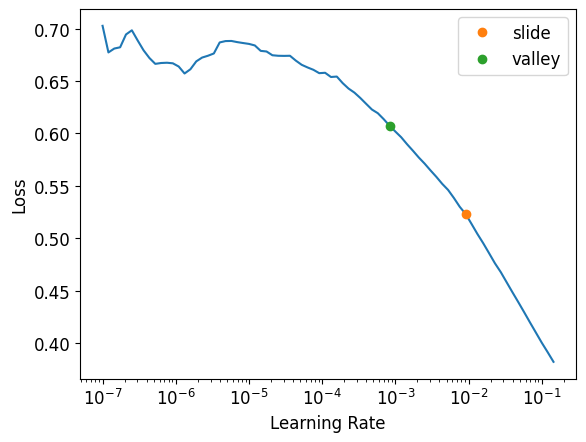

In [16]:
learn = tabular_learner(dls, metrics=R2Score())
learn.lr_find(suggest_funcs=(slide,valley))

In [17]:
%%time
learn.fit_one_cycle(9,0.008)

epoch,train_loss,valid_loss,r2_score,time
0,0.000706,0.000435,0.833703,03:07
1,0.000507,0.000446,0.829319,03:10
2,0.000516,0.000440,0.831672,03:13
3,0.000479,0.000407,0.844248,03:19
4,0.000449,0.000401,0.846478,03:30
5,0.000463,0.000398,0.847869,03:30
6,0.000430,0.000397,0.848303,03:34
7,0.000402,0.000372,0.857865,03:32
8,0.000384,0.000367,0.859835,03:32


In [19]:
dl = learn.dls.test_dl(test_df)

In [20]:
%%time
nn_preds = learn.get_preds(dl=dl)
nn_preds_x = learn.get_preds()[0]
a_preds, _ = learn.get_preds(dl=dl)
nn_preds_y = a_preds.squeeze(1)

CPU times: user 4min 48s, sys: 1.06 s, total: 4min 49s
Wall time: 2min 28s


In [22]:
learn.export('fp_model.pkl')

In [26]:
#learn.load('fp_model.pkl')

In [21]:
r2_score(y_test,nn_preds_x)

0.8598348134200537

In [25]:
target_preds = nn_preds[0]

In [26]:
test_df['FloodProbability'] = target_preds

In [27]:
test_df.to_csv('submission.csv', columns=['FloodProbability'], index=True)

In [28]:
submission = pd.read_csv('submission.csv')
submission.head()

,id,FloodProbability
0,1117957,0.572894
1,1117958,0.456933
2,1117959,0.452724
3,1117960,0.471749
4,1117961,0.472386


In [29]:
!ls

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


models	submission.csv


In [23]:
test_df['FloodProbability'] = target_preds
test_df.to_csv('submission.csv', columns=['FloodProbability'], index=True)

submission = pd.read_csv('submission.csv')
submission.head()

,id,FloodProbability
0,1117957,0.570037
1,1117958,0.454809
2,1117959,0.450980
3,1117960,0.472557
4,1117961,0.471661


# Random Forest Baseline

In [ ]:
rf = RandomForestRegressor(100, min_samples_leaf=3)
rf_model = rf.fit(X_train, y_train);

rf_preds = tensor(rf_model.predict(test_dl.xs))

rf_preds_x = tensor(rf_model.predict(X_test))

mse = mean_absolute_error(y_test, rf_preds_x)
rmse = np.sqrt(mse)

r2_score(y_test,rf_preds_x)

In [30]:
!ls

models	submission.csv


# CatBoost Baseline

In [ ]:
import optuna
import optuna_distributed
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score

def objective_catboost(trial):
    params = {
        "iterations": 200,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "random_strength": trial.suggest_int("random_strength", 1, 10),
    }
    model = CatBoostRegressor(**params, silent=True)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)
    cat_predictions = model.predict(X_test)
    r2score = r2_score(y_test, cat_predictions)
    return r2score

# Create a study
study_catboost = optuna.create_study(direction='minimize')

# Convert the study to a distributed study
study_catboost = optuna_distributed.from_study(study_catboost)

# Run the optimization with parallel processing
num_parallel_jobs = 4 # Adjust this based on your system's capabilities
study_catboost.optimize(objective_catboost, n_trials=40, n_jobs=num_parallel_jobs)

print(study_catboost.best_params)

In [29]:
#with optuna params
cat_model = CatBoostRegressor(iterations=500, depth=10, learning_rate= 0.08, random_strength=8)
cat_model = cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

#test set preds
cat_preds = tensor(cat_model.predict(test_dl.xs))

#validation set preds
cat_preds_x = tensor(cat_model.predict(X_test))

r2_score(y_test,cat_preds_x)

0.8455868940867239

# Light GBM

In [ ]:
def objective_lgbm(trial):
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 20, 50),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 200),
    }
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)
    lgb_predictions = model.predict(X_test)
    r2score = r2_score(y_test, lgb_predictions)
    return r2score

# Create a study
study_lgbm = optuna.create_study(direction='minimize')

# Convert the study to a distributed study
study_lgbm = optuna_distributed.from_study(study_lgbm)

# Run the optimization with parallel processing
num_parallel_jobs = 4 # Adjust this based on your system's capabilities
study_lgbm.optimize(objective_lgbm, n_trials=100, n_jobs=num_parallel_jobs)

print(study_lgbm.best_params)


In [30]:
lgb_model = lgb.LGBMRegressor(num_leaves=47, learning_rate=0.19470589857022183, n_estimators=165)
lgb_model = lgb_model.fit(X_train, y_train)

#test set preds
lgb_preds = tensor(lgb_model.predict(test_dl.xs))

#validation set preds
lgb_preds_x = tensor(lgb_model.predict(X_test))


r2_score(y_test,lgb_preds_x)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.169354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 894366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504482


0.8246920206816482

# XGBoost

In [ ]:
def objective_xgboost(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 200),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.1, 1.0),
    }
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)
    xgb_predictions = model.predict(X_test)
    r2score = r2_score(y_test, xgb_predictions)
    return r2score


study_xgboost = optuna.create_study(direction='minimize')
study_xgboost = optuna_distributed.from_study(study_xgboost)

# Run the optimization with parallel processing
num_parallel_jobs = 4 # Adjust this based on your system's capabilities
study_lgbm.optimize(objective_lgbm, n_trials=100, n_jobs=num_parallel_jobs)

print(study_lgbm.best_params)
study_xgboost.optimize(objective_xgboost, n_trials=30)
print(study_xgboost.best_params)

In [31]:
xgb_model = xgb.XGBRegressor(n_estimators = 187, max_depth=8, learning_rate=0.08, subsample=0.7091172175235119)
xgb_model = xgb_model.fit(X_train, y_train)

xgb_preds = tensor(xgb_model.predict(test_dl.xs))

xgb_preds_x = tensor(xgb_model.predict(X_test))

r2_score(y_test,xgb_preds_x)

0.8222910699137722

# General Ensemble

In [32]:
nn_preds_m = nn_preds_x.squeeze()

NameError: name 'nn_preds_x' is not defined

In [48]:
#for r2_Score testing
general_preds = (lgb_preds_x + xgb_preds_x + cat_preds_x + nn_preds_m)/4
general_preds

tensor([0.4972, 0.5185, 0.4980,  ..., 0.5702, 0.4997, 0.4677])

In [33]:
#for r2_Score testing
general_preds = (lgb_preds_x + xgb_preds_x + cat_preds_x )/3
general_preds

tensor([0.4561, 0.4878, 0.5120,  ..., 0.5509, 0.3689, 0.5528])

In [63]:
#for r2_Score testing
general_preds = (lgb_preds_x + xgb_preds_x + cat_preds_x + nn_preds_m + rf_preds_x)/5
general_preds

tensor([0.4993, 0.5142, 0.4981,  ..., 0.5651, 0.5001, 0.4727])

In [50]:
general_preds.shape

torch.Size([223591])

In [46]:
#use for submission
general_preds = (lgb_preds + xgb_preds + cat_preds + nn_preds_y)/4               
general_preds

tensor([0.5711, 0.4605, 0.4595,  ..., 0.6164, 0.5486, 0.5107])

In [37]:
#use for submission
general_preds = (lgb_preds + xgb_preds + cat_preds )/3              
general_preds

tensor([0.5675, 0.4572, 0.4561,  ..., 0.6193, 0.5453, 0.5095])

# Scoring

In [49]:
r2_score(y_test,general_preds)

0.8414001174588646

In [57]:
lgb_preds_x.shape,xgb_preds_x.shape,cat_preds_x.shape,nn_preds_x.shape,nn_preds_z.shape,(nn_preds_x.squeeze()).shape,rf_preds_x.shape             

(torch.Size([223591]),
 torch.Size([223591]),
 torch.Size([223591]),
 torch.Size([223591, 1]),
 torch.Size([745305]),
 torch.Size([223591]),
 torch.Size([223591]))

In [ ]:
a_preds.shape

In [29]:
lgb_preds.shape,xgb_preds.shape,cat_preds.shape,nn_preds_y.shape             
              

(torch.Size([745305]),
 torch.Size([745305]),
 torch.Size([745305]),
 torch.Size([745305]))

In [ ]:
y_test.shape,X_train.shape

In [ ]:
nn_preds_y.shape,nn_preds_x.shape    

In [39]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['FloodProbability'] = general_preds
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')

In [40]:
!ls

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


catboost_info  submission.csv


In [21]:
!rm submission.csv